In [ ]:
#!pip install pydrive
import os
from zipfile import ZipFile
from shutil import copy
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

#File is here
#https://drive.google.com/open?id=1Fpcie26I9WBRUdqNObwd1tfjRk92ON3B
fileId = '1Fpcie26I9WBRUdqNObwd1tfjRk92ON3B'

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

fileName = fileId + '.zip'
downloaded = drive.CreateFile({'id': fileId})
downloaded.GetContentFile(fileName)
ds = ZipFile(fileName)
ds.extractall()
os.remove(fileName)
print('Extracted zip file ' + fileName)

os.chdir('wedges')
!ls -lah

# Описание процесса

---

Есть производство некоторого продукта посредством электролиза (нагреваемый ящик, стоит в неотапливаемом помещении). Заглядывать в ящик часто нельзя - лабораторный сбор по уточнению процентного содержания в смеси происходит дважды в день, хотелось бы делать замеры еще реже и в перспективе полагатсья только на модель - отсюда и задача. Требуется предсказать по данным (до 2018-10-18) с различных датчиков процентное содержание продукта в смеси файл **target.csv**.

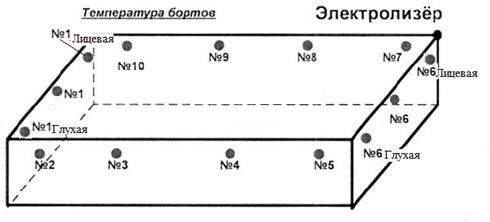

In [ ]:
from IPython.display import Image
Image('boards.jpg')

# В качестве данных доступны



---

Файл **3min Series (00sec) Outer new**:



*   **Шум** в электрике
*   **Обратная ЭДС** (Электродвижущая сила) сети устройства
*   **Ср.прир.напр** Средний прирост напряжения в сети
*   **Сум.доз АПГ** Сумма доз АПГ (происходит периодичный вброс катализатора в ящик - это число соответствует кол-ву раз которое производилось вбрасывание за промежуток времени)
*   **Температурные датчики** (ящик прямоугольной формы, они располагаются по всему периметру, нумерация вдоль длины ящика дана как пример):
1.   **Board Temp. {i}** - датчики температуры по длинне ящика с обоих сторон
2.   **Board Face Temp. {1,6}** - датчики с лицевой стороны
3.   **Board Deaf Temp. {1,6}** - датчики с тыльной стороны



Файл **Средняя масса доли АПГ New** : 

массовые доли каждого из вбросов показателя **Сумма доз АПГ**. То есть можно понять сколько массы было вброшено в период **Итог масс АПГ = Сум.доз АПГ * avg_mass_apg**.

In [ ]:
import pandas as pd
import numpy as np
# Visualization Packages
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import pylab as pl

In [ ]:
data = pd.read_csv('3min Series (00sec) Outer new.csv')
target = pd.read_csv('target.csv', sep=';')
mass = pd.read_csv('╨í╤Ç╨╡╨┤╨╜╤Å╤Å ╨╝╨░╤ü╤ü╨░ ╨┤╨╛╨╗╨╕ ╨É╨ƒ╨ô New.csv')

target.columns = ["Date", "product_percents"]

data['Date'] =  pd.to_datetime(data['Date']) #format='%Y-%m-%d %H:%M:%S'
target['Date'] =  pd.to_datetime(target['Date']) #format='%Y-%m-%d %H:%M:%S'
mass['Date'] =  pd.to_datetime(mass['Dateparse']) #format='%Y-%m-%d %H:%M:%S'

mass = mass.drop(['Dateparse'], axis=1)

In [ ]:
print("Target data time range")
#target.set_index('Date', inplace=True)
print(target.Date.min())
print(target.Date.max())

#We need just this subset based on the task
data = data.sort_values('Date')
data = data[(data['Date'] <= "2018-10-18 14:00:00") & (data['Date'] >= "2018-07-28 05:00:00")]

#data.set_index('Date', inplace=True)
print("Main data time range")
print(data.Date.min())
print(data.Date.max())

Target data time range
2018-07-28 05:00:00
2018-10-18 14:00:00
Main data time range
2018-07-28 05:01:00
2018-10-18 13:58:00


In [ ]:
data.head()

,Date,Шум,Обратная ЭДС,Ср.прир.напр.,Сум.доз АПГ,Board Temp. 1,Board Temp. 2,Board Temp. 3,Board Temp. 4,Board Temp. 5,Board Temp. 6,Board Temp. 7,Board Temp. 8,Board Temp. 9,Board Temp. 10,Board Face Temp. 1,Board Face Temp. 6,Board Deaf Temp. 1,Board Deaf Temp. 6
51995,2018-07-28 05:01:00,NaN,NaN,-1.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51179,2018-07-28 05:04:00,NaN,NaN,-1.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51771,2018-07-28 05:07:00,NaN,NaN,-1.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52206,2018-07-28 05:10:00,NaN,NaN,-2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51449,2018-07-28 05:13:00,NaN,NaN,-0.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data.shape

(39520, 19)

In [ ]:
target.head()

,Date,product_percents
0,2018-07-28 05:00:00,3.68
1,2018-07-28 14:00:00,3.49
2,2018-07-29 05:00:00,3.61
3,2018-07-29 14:00:00,3.65
4,2018-07-30 05:00:00,3.41


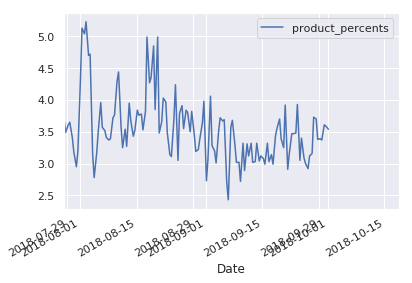

In [ ]:
lines = target.plot.line(x = 'Date', y ='product_percents')

In [ ]:
data = data.sort_values('Date')
mass = mass.sort_values('Date')

print("Main data shape: " + str(data.shape))
print("Target data shape: " + str(target.shape))
print("Mass data shape: " + str(mass.shape))

Main data shape: (39520, 19)
Target data shape: (166, 2)
Mass data shape: (2028, 2)


In [ ]:
data.dtypes

Date                  datetime64[ns]
Шум                          float64
Обратная ЭДС                 float64
Ср.прир.напр.                float64
Сум.доз АПГ                  float64
Board Temp. 1                float64
Board Temp. 2                float64
Board Temp. 3                float64
Board Temp. 4                float64
Board Temp. 5                float64
Board Temp. 6                float64
Board Temp. 7                float64
Board Temp. 8                float64
Board Temp. 9                float64
Board Temp. 10               float64
Board Face Temp. 1           float64
Board Face Temp. 6           float64
Board Deaf Temp. 1           float64
Board Deaf Temp. 6           float64
dtype: object

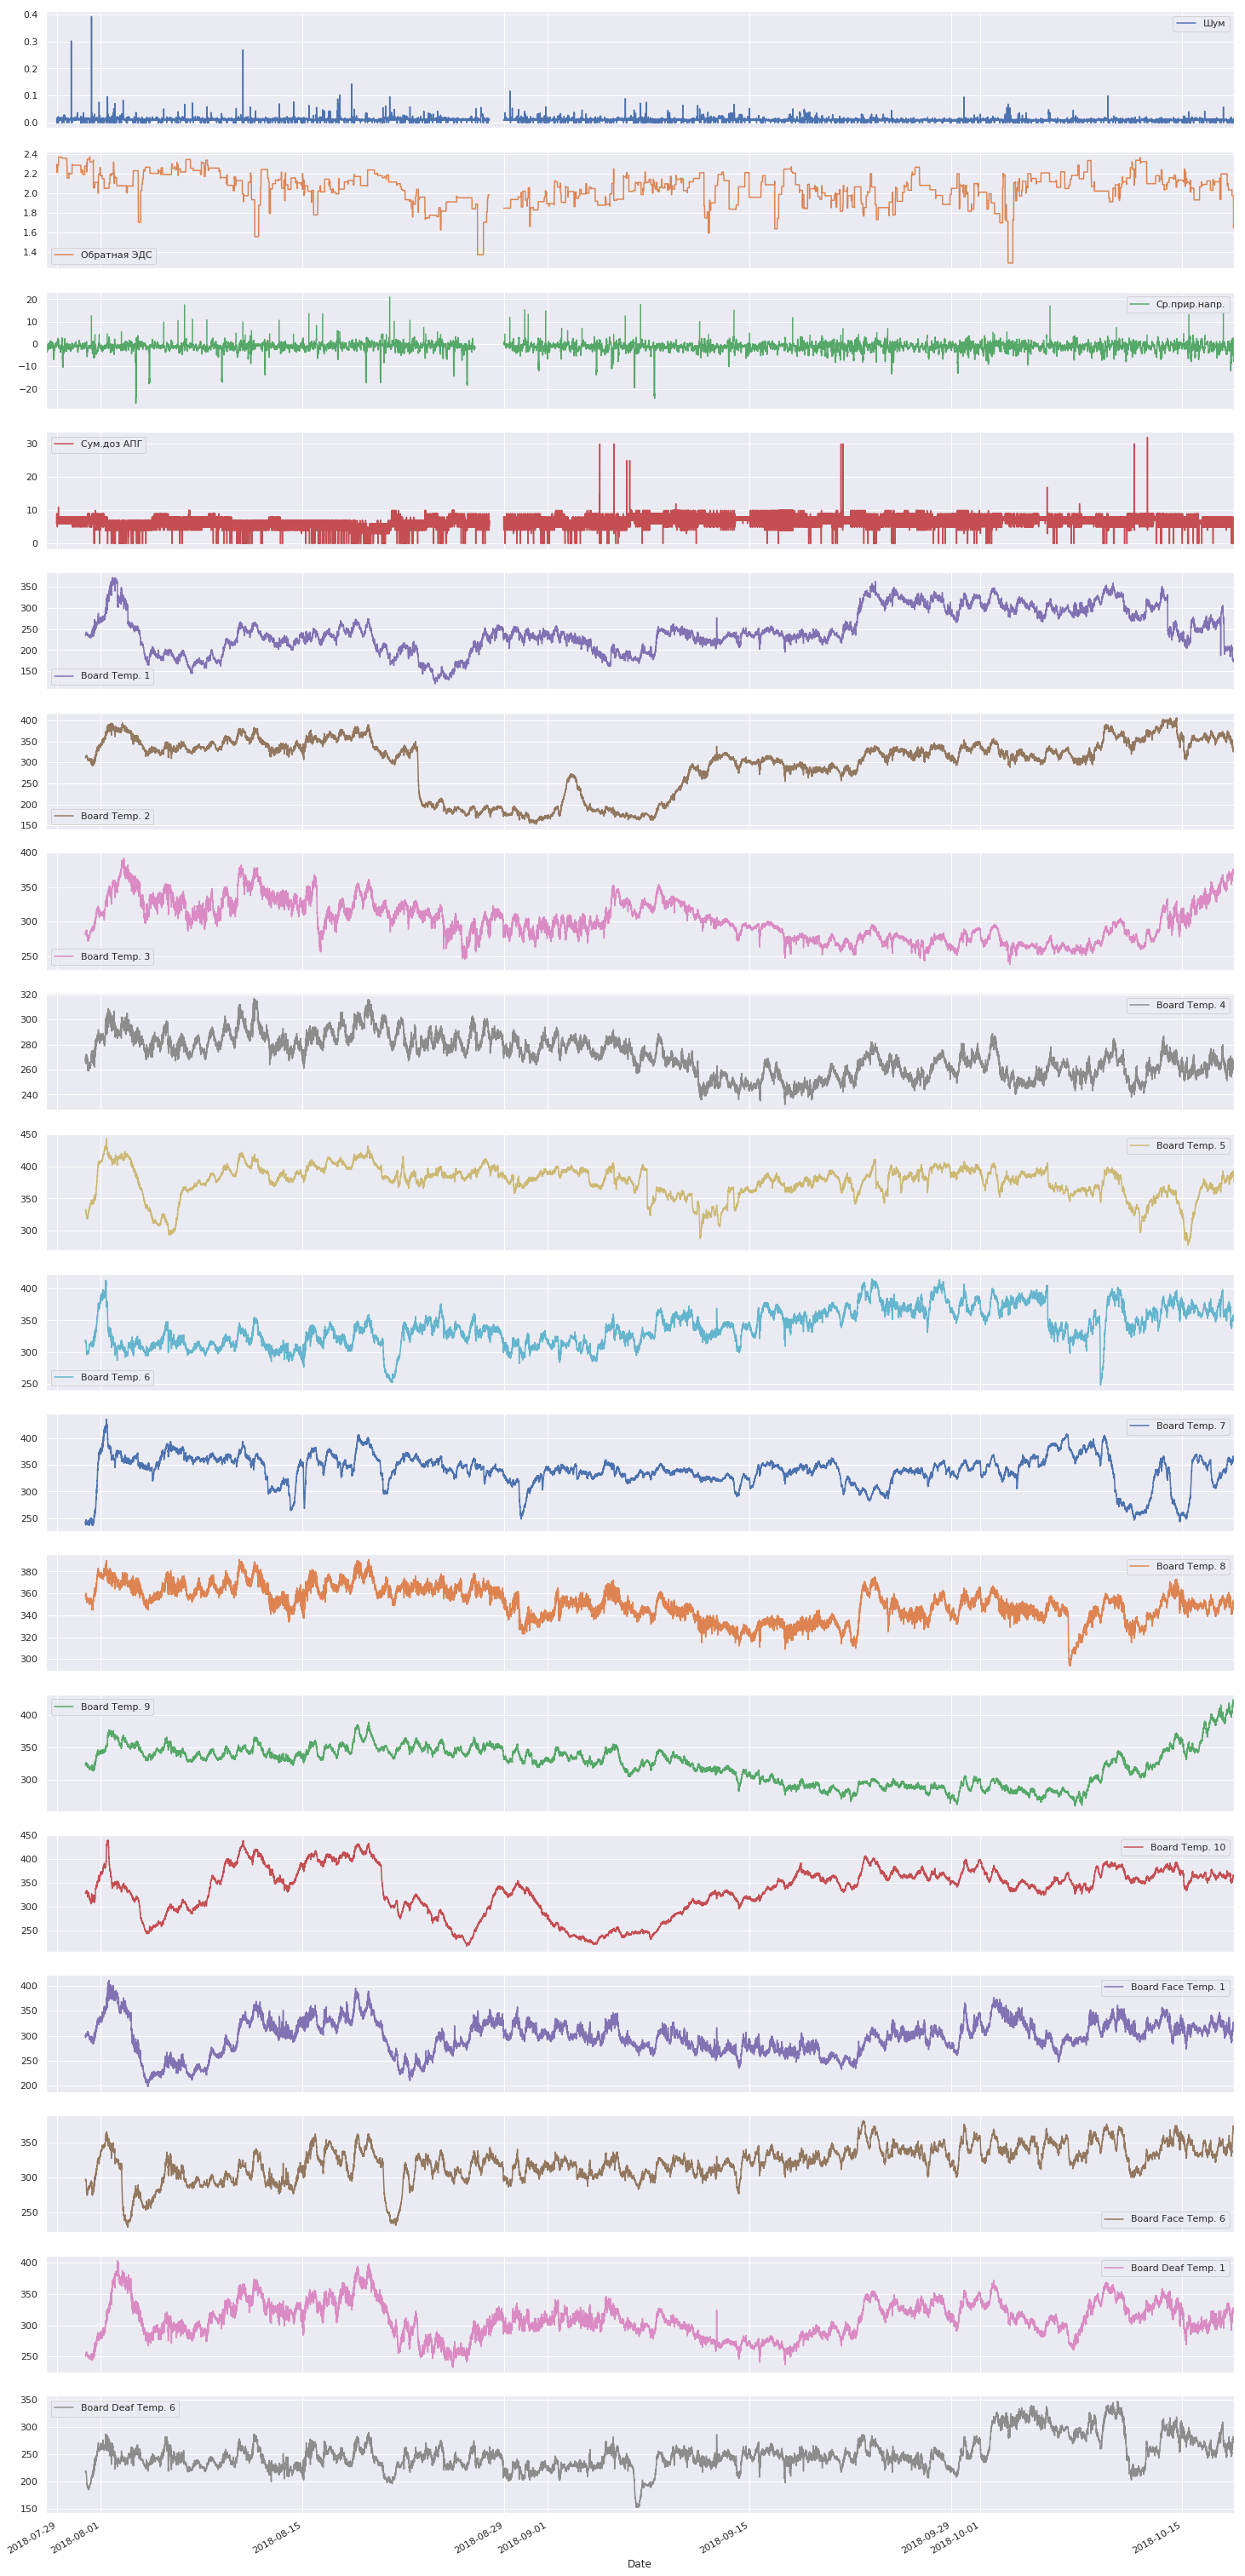

In [ ]:
data.set_index('Date', inplace=True)
data.plot(subplots = True, figsize = (25, 60));

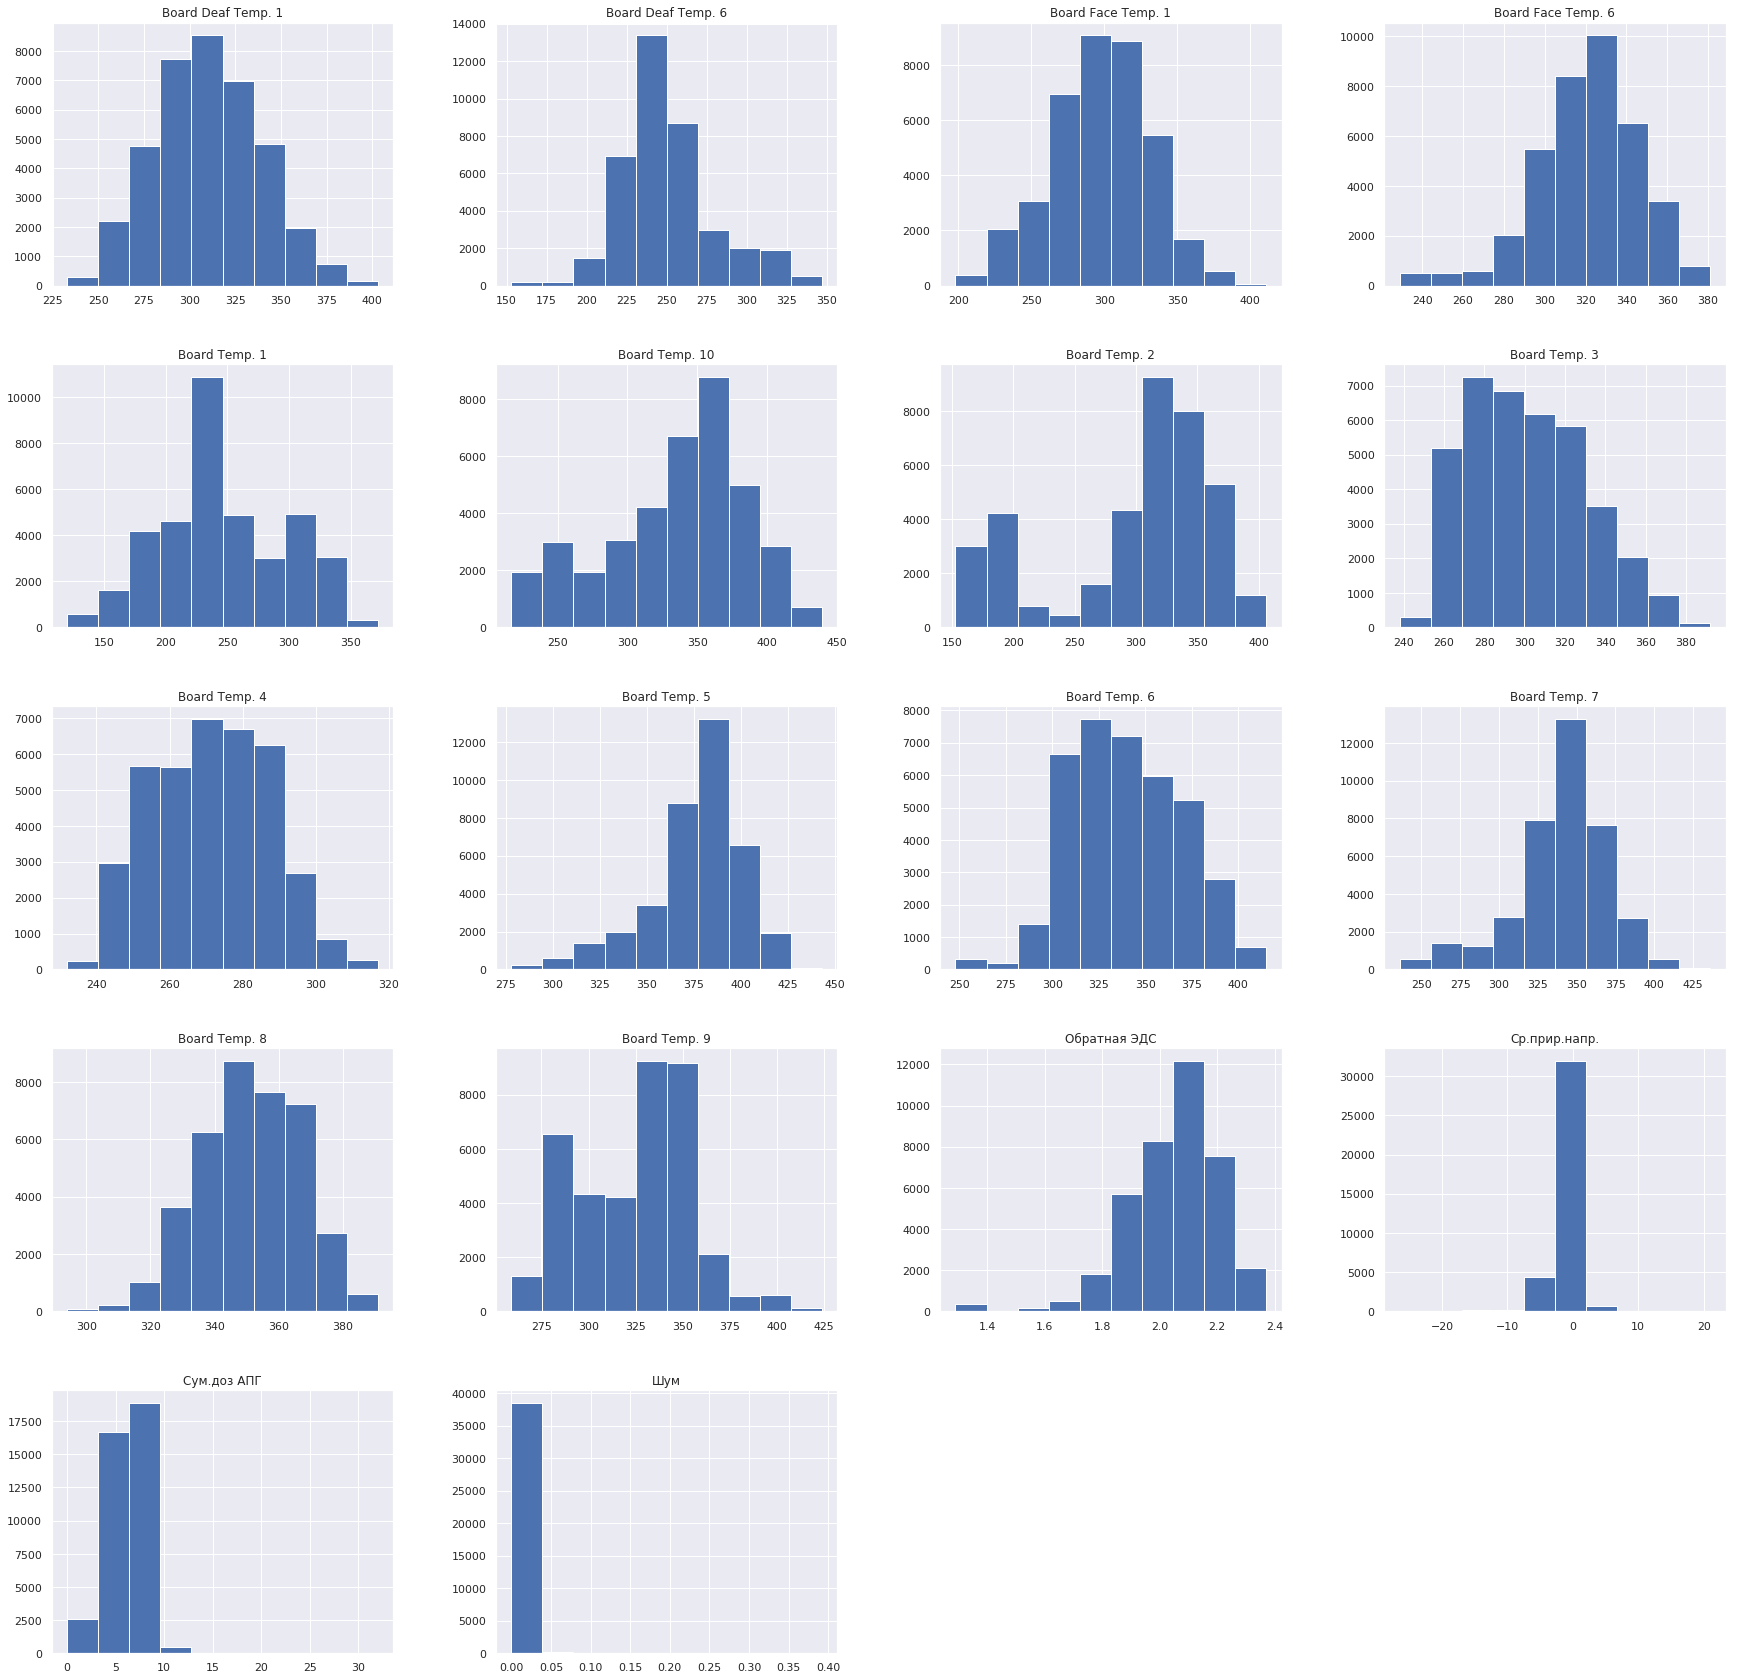

In [ ]:
data.hist(figsize=(30, 30))
plt.show()

A useful type of plot to explore the relationship between each observation and a lag.

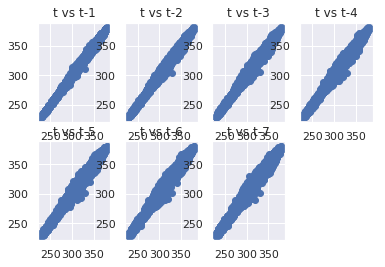

In [ ]:
from pandas import concat

values = pd.DataFrame(data["Board Face Temp. 6"].values)
lags = 7
columns = [values]
for i in range(1,(lags + 1)):
  columns.append(values.shift(i))
dataframe = concat(columns, axis=1) 
columns = ['t']
for i in range(1,(lags + 1)):
  columns.append('t-' + str(i)) 
dataframe.columns = columns 
plt.figure(1)
for i in range(1,(lags + 1)):
  ax = plt.subplot(240 + i)
  ax.set_title('t vs t-' + str(i))
  plt.scatter(x = dataframe['t'].values, y = dataframe['t-'+str(i)].values)
plt.show()

Lack of strong correlation in:

*   Шум
*   Обратная ЭДС
*   Ср.прир.напр.
*   Сум.доз АПГ

---



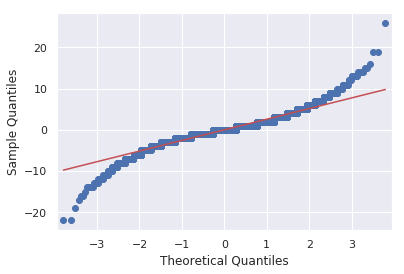

In [ ]:
from statsmodels.graphics.gofplots import qqplot

values = pd.DataFrame(data["Board Deaf Temp. 6"].values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t', 't+1']
# split into train and test sets
X = dataframe.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]
# persistence model
predictions = [x for x in test_X]
# calculate residuals
residuals = [test_y[i]-predictions[i] for i in range(len(predictions))] 
residuals = np.array(residuals)
qqplot(residuals, line='r')# figsize=(30, 30)
plt.show()

Not normal:
*   Шум
*   Обратная ЭДС
*   Ср.прир.напр.
*   Сум.доз АПГ




# Cleaning

*   changing the frequency of a time series (upsampling and downsampling)
*   missing data
*   outliers
*   smoothing data
*  addressing seasonality in data
*  preventing unintentional lookaheads



MULTIVARIATE TIME SERIES
Multivariate time series are series with multiple variables measured at each timestamp. Multivariate time series are particularly rich for analysis because often the measured variables are interrelated and show temporal dependencies between one another.

Calculate the differences to get a sense of spacing between data entries (depending on your working hypothesis of what the times indicate, a user behavior or a network behavior)


Another situation could involve physical knowledge of the limits of the system. For example, there is a limit to how quickly blood glucose can change in a person, so if you are looking at a series of blood glucose measurements within seconds of one another, you should probably average these rather than treating them as distinct data points. Any physician will tell you that you are studying the error of the device rather than the rate of change of blood glucose if you are looking at many measurements within a few seconds of one another.

## Changing the frequency of a time series (upsampling in this case)
Often related time series data from different sources of information will not have the same sampling frequency. This is one reason, among many, that you might wish to change the sampling frequency of your data. Of course you cannot change the actual rate at which information was measured, but you can change the frequency of the timestamps in your data collection. This is called upsampling and downsampling, depending on whether you increase or decrease the timestamp frequency.

**Irregular** time series
A very common reason to upsample is that you have an irregularly-sampled time series and you want to convert it to a regularly-timed one. This is a form of upsampling because you are converting all the data to a frequency that is likely higher than indicated by the lags between your data.

Upsampling is not simply the inverse of downsampling. Downsampling intrinsically makes sense as something that can be done in the real world. It is simple to decide to measure less often. In contrast, upsampling can be like trying to get something for free. That is, not taking a measurement but still somehow thinking you can get high resolution data from infrequent measurements. To quote the author of the popular R time series package XTS:

In [ ]:
#Works super long, see the result
#from tqdm import tqdm

#a = data['Date'][1+1] - data['Date'][1]
#data['time_diff2'] = a

#for i in tqdm(range(data.shape[0] - 1)):
#  data['time_diff2'][i+1] = data['Date'][i+1] - data['Date'][i]



#RESULT
#data['time_diff'].value_counts()

#00:03:00    39505
#00:06:00       11
#00:09:00        4

In [ ]:
#data = data.reset_index()

#data = data.set_index('Date').resample('3Min').mean().transform(pd.Series.interpolate).reset_index()
#data["Date"] = data["Date"] + pd.Timedelta(minutes=1)
#data.shape

(39542, 20)

## Treating missing values

**Gaps in the data**

---

Sensors sometimes drop out. But for modelling purposes, we need a gap-free dataset. Systematically missing data sets - our data is noisy, and you have reason to doubt the value of any individual data point relative to an overall mean, you should use a moving average rather than forward filling.

---

The most common methods to address missing data in time series are:

1.   Mean or mode imputation. Imputation is when we fill in missing data based on observations about the entire data set
2.   Interpolation, generally linear or with a spline. Interpolation is when we use neighboring data points to estimate the missing value.
3.   Deletion of affected time periods. This is when we choose not to use time periods that have missing data.

*   forward fill - There are many advantages to forward fill: it is not computationally demanding, it can be easily applied to live-streamed data and it does a respectable job with imputation. 
*   moving average -  impute data either with a rolling mean or median, using past values to “predict” missing future values (imputation can be a form of prediction).
*   interpolation



We will compare the performance of these methods in both the randomly missing and systematically missing data sets. Since we have generated these data sets from a complete data set, we can in fact determine how they did instead of speculating. In the real world, of course, we will never have the missing data to check our data imputation.

## Result treating missing values


In [ ]:
data['Шум_int'] = data['Шум'].fillna(method='ffill').fillna(method='bfill')
data["Обратная_ЭДС_int"] = data["Обратная ЭДС"].fillna(method='ffill').fillna(method='bfill')
data["Ср.прир.напр._int"] = data["Ср.прир.напр."].fillna(method='ffill').fillna(method='bfill')
data["Сум.доз_АПГ_int"] = data["Сум.доз АПГ"].fillna(method='ffill').fillna(method='bfill')

print(data.isnull().sum())

Шум                    837
Обратная ЭДС           837
Ср.прир.напр.         2035
Сум.доз АПГ            836
Board Temp. 1         1314
Board Temp. 2         1314
Board Temp. 3         1314
Board Temp. 4         1314
Board Temp. 5         1314
Board Temp. 6         1314
Board Temp. 7         1314
Board Temp. 8         1314
Board Temp. 9         1314
Board Temp. 10        1314
Board Face Temp. 1    1314
Board Face Temp. 6    1314
Board Deaf Temp. 1    1314
Board Deaf Temp. 6    1314
Шум_int                  0
Обратная_ЭДС_int         0
Ср.прир.напр._int        0
Сум.доз_АПГ_int          0
dtype: int64


experiments/fitting

Text(0, 0.5, 'Value')

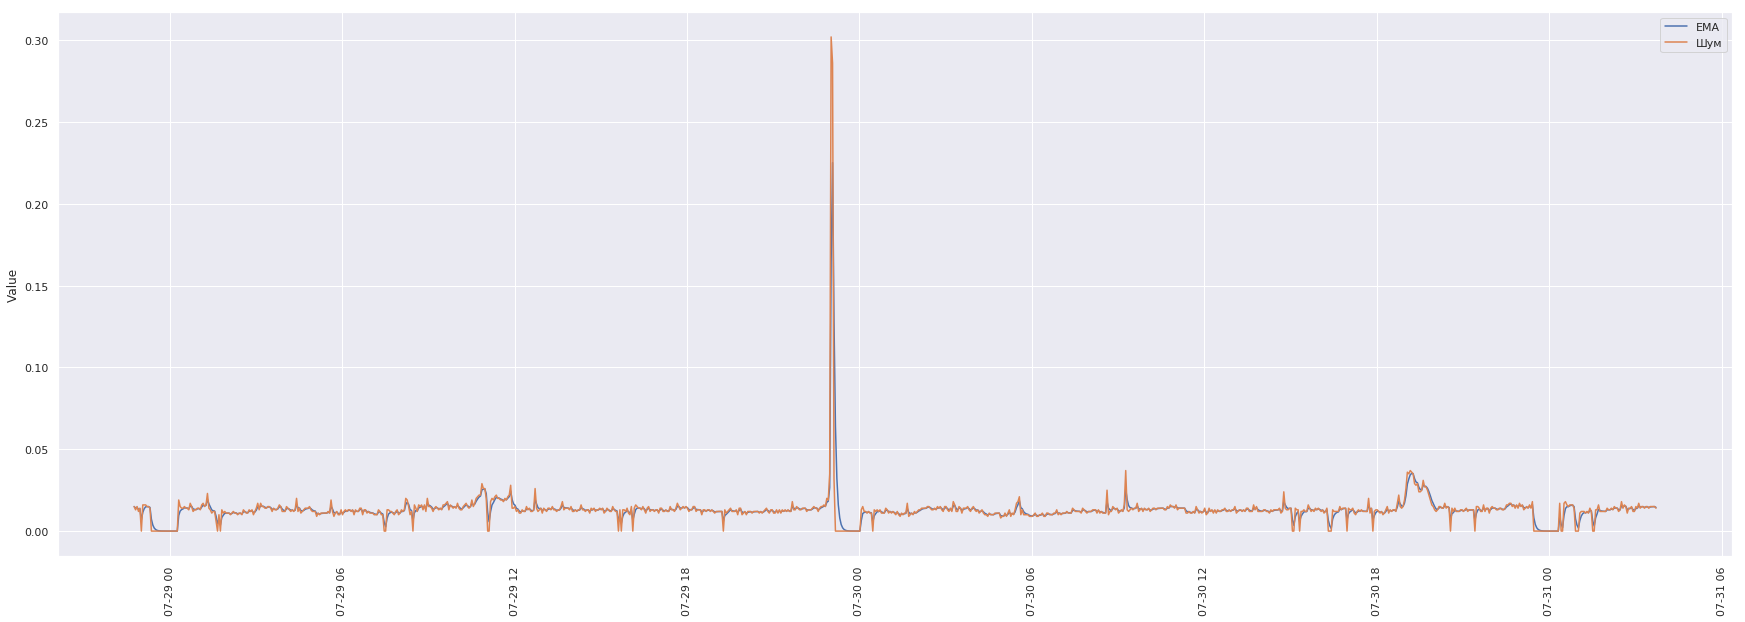

In [ ]:
#Exponential moving average
#data.set_index('Date', inplace=True)
#data = data.reset_index()

#data["Шум_ema"] = data['Шум'].ewm(span=3, adjust=False).mean()
#data["Шум_lint"] = data["Шум"].interpolate(kind = 'linear')
#data["Board Deaf Temp. 1_cint"] = data["Board Deaf Temp. 1"].interpolate(kind = 'cubic')


start_date, end_date = '2018-07-28 05:01:00', '2018-07-31 03:43:00' 
fig, ax = plt.subplots(figsize=(30, 10)) 

ax.plot(data.loc[start_date:end_date, :].index, data.loc[start_date:end_date, 'Шум_ema'], label='EMA')
ax.plot(data.loc[start_date:end_date, :].index, data.loc[start_date:end_date, 'Шум'], label = 'Шум')
plt.xticks(rotation=90)
ax.legend(loc='best')
ax.set_ylabel('Value')

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

noise = data[['Шум_int']]
scaler = StandardScaler()
np_scaled = scaler.fit_transform(noise)
noise = pd.DataFrame(np_scaled)

# train isolation forest
model =  IsolationForest(contamination = 0.0005)
model.fit(noise) 
data['anomaly'] = pd.Series(model.predict(noise))

In [ ]:
data = data.reset_index()
fig, ax = plt.subplots(figsize=(30, 10)) 
a = data.loc[data['anomaly'] == -1, ['Date', 'Шум_int']] #anomaly

ax.plot(data['Date'], data['Шум_int'], color='blue', label = 'Normal')
ax.scatter(a['Date'], a['Шум_int'], color='red', label = 'Anomaly')
plt.legend()
plt.xticks(rotation=90)
plt.show()

data.loc[data['anomaly'] == -1] = np.nan

# Smoothing

While outlier detection is a topic in and of itself, if you have reason to believe your series should be smoothed, you can smooth your data with a moving average to eliminate measurement spikes, errors of measurement, or both. Even if the spikes are accurate, they may not reflect the underlying process and may be more a matter of instrumentation problems.

Smoothing is a technique applied to time series to remove the fine-grained variation betweentime steps.  The hope of smoothing is to remove noise and better expose the signal of theunderlying causal processes.  Moving averages are a simple and common type of smoothingused in time series analysis and time series forecasting.  Calculating a moving average involvescreating a new series where the values are comprised of the average of raw observations in theoriginal time series.


Calculating a moving average of a time series makes some assumptions about your data.  It isassumed that both trend and seasonal components have been removed from your time series.This means that your time series is stationary, or does not show obvious trends (long-termincreasing or decreasing movement) or seasonality (consistent periodic structure).There are many methods to remove trends and seasonality from a time series dataset whenforecasting.  Two good methods for each are to use the differencing method and to model thebehavior and explicitly subtract it from the series.

# Noise filtering


The rest of the analysis is dedicated to "signal processing" kind of analysis and is generally not suitable for general-purpose time series.

---

To reduce the noise in the data, we can smooth it. There are various ways to do this and so there is a choice to be made about the method to use and the degree of smoothing required. pandas offers a convenient way to reduce the data cadence by resampling with the .resample() method:

*   Exponential moving average smoothing filter
*   Kalman filters / Bayesian Filters
*   FIR filters
*   Fourier smoothing/ Fourier transform
*   Wavelet shrinkage - Locally Stationary Wavelet 
*   Discrete cosine transform
*   LOESS - locally estimated scatter plot smoothing


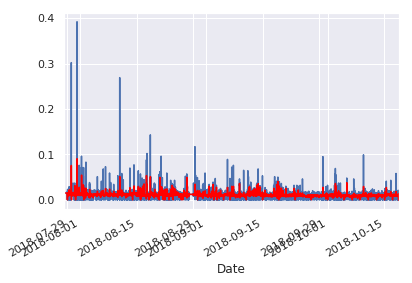

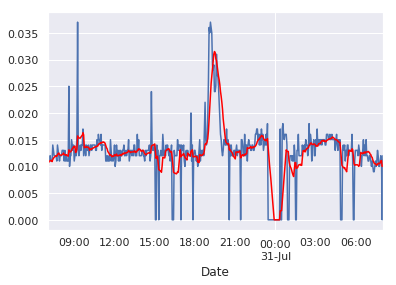

In [ ]:
# tail-rolling average transform
ts = data["Шум_int"]
rolling = ts.rolling(window = 10) 
rolling_mean = rolling.mean() 
# plot original and transformed dataset 
ts.plot() 
rolling_mean.plot(color='red') 
plt.show()
# zoomed plot original and transformed dataset
ts[1000:1500].plot() 
rolling_mean[1000:1500].plot(color='red') 
plt.show()
data["Шум_int_smooth"] = rolling_mean

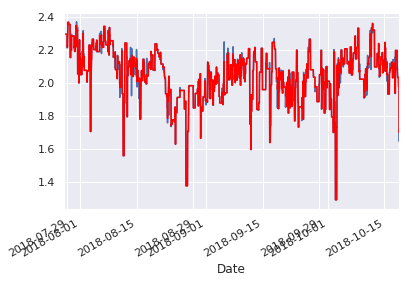

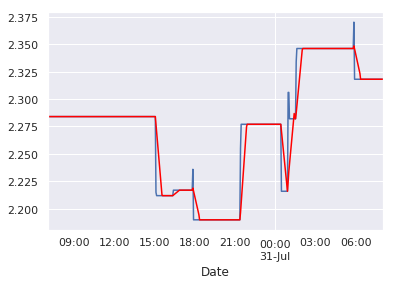

In [ ]:
# tail-rolling average transform
ts = data["Обратная_ЭДС_int"]
rolling = ts.rolling(window=10) 
rolling_mean = rolling.mean() 
# plot original and transformed dataset 
ts.plot() 
rolling_mean.plot(color='red') 
plt.show()
# zoomed plot original and transformed dataset
ts[1000:1500].plot() 
rolling_mean[1000:1500].plot(color='red') 
plt.show()
data["Обратная_ЭДС_int_smooth"] = rolling_mean

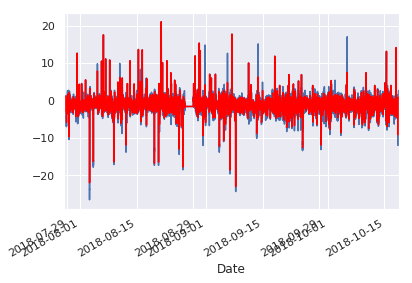

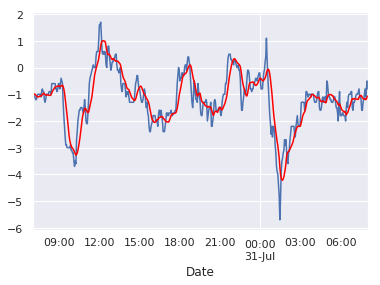

In [ ]:
# tail-rolling average transform
ts = data["Ср.прир.напр._int"]
rolling = ts.rolling(window=10) 
rolling_mean = rolling.mean() 
# plot original and transformed dataset 
ts.plot() 
rolling_mean.plot(color='red') 
plt.show()
# zoomed plot original and transformed dataset
ts[1000:1500].plot() 
rolling_mean[1000:1500].plot(color='red') 
plt.show()
data["Ср.прир.напр._int_smooth"] = rolling_mean

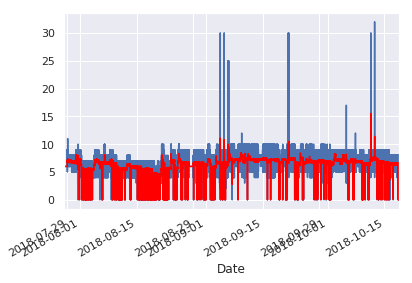

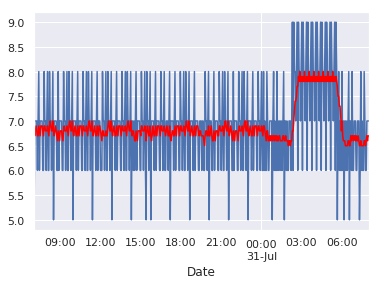

In [ ]:
# tail-rolling average transform
ts = data["Сум.доз_АПГ_int"]
rolling = ts.rolling(window=10) 
rolling_mean = rolling.mean() 
# plot original and transformed dataset 
ts.plot() 
rolling_mean.plot(color='red') 
plt.show()
# zoomed plot original and transformed dataset
ts[1000:1500].plot() 
rolling_mean[1000:1500].plot(color='red') 
plt.show()
data["Сум.доз_АПГ_int_smooth"] = rolling_mean

In [ ]:
# tail-rolling average transform
ts = data["Board Temp. 1"]
rolling = ts.rolling(window = 1000) 
rolling_mean = rolling.mean().interpolate(method='linear', limit_direction='backward')
# plot original and transformed dataset 
ts.plot() 
rolling_mean.plot(color = 'red') 
plt.show()
# zoomed plot original and transformed dataset
ts[1000:1500].plot() 
rolling_mean[1000:1500].plot(color = 'red') 
plt.show()
data["Board_Temp._1_smooth"] = rolling_mean

# Kalman filter
Kalman filter, but again, it's not obvious to tune and you'd need some more understanding of your signal and the Kalman filter to implement it succesfuly.

Kalman filters which apply a Bayesian approach to the data to treat the noise or changes in the data as partly a result of error, and LOWESS smoothing, a non-parametric method of locally smoothing data, which is highly computationally taxing. 

In [ ]:
#!pip install pykalman
#from pykalman import UnscentedKalmanFilter
#ts = data["Board Temp. 1"]

#ukf = UnscentedKalmanFilter(lambda x, w: x + np.sin(w), lambda x, v: x + v, observation_covariance = 0.5)
#(filtered_state_means, filtered_state_covariances) = ukf.filter(ts)
#(smoothed_state_means, smoothed_state_covariances) = ukf.smooth(ts)

Kalman Filter is an optimal estimation algorithm to estimate the variable which can be measured indirectly and to find the best estimate of states by combining measurement from various sensors in the presence of noise. Kalman Filters is ideal for systems which are continuously changing and well suited for building real time systems as kalman filter is a dynamic linear model, that is able to adapt to an ever changing environment. The major advantage of Kalman Filter is that it is predictive , adaptive as well and and it is really fast as it doesn’t tracks the historical data but rather the previous state.

# lowess - computational heavy


In [ ]:
#lowess - computational heavy

#x = data["noise_ffill2"]
#Case1: Sinusoidal Fitting 
#y = np.sin(x) + 0.3 * np.random.randn(len(x)) 
    
#Case2 : Straight Line Fitting
#y= 1 + 0.25*np.random.randn(n) # For Linear
 
#ypred = lowess(x, y, f= 0.25, iter=3)
    
#import pylab as pl
#pl.clf()
#pl.plot(x, y, label='Y NOISY')
#pl.plot(x, ypred, label='Y PREDICTED')
#pl.legend()
#pl.show()

# Result smoothing 

In [ ]:
pd.options.mode.chained_assignment = None  # default='warn'
#data = data.reset_index()

data["Шум_int_smooth"] = data["Шум_int"].rolling(window = 50).mean().interpolate(method='linear', limit_direction='backward')
data["Сум.доз_АПГ_int_smooth"] = data["Сум.доз_АПГ_int"].rolling(window = 50).mean().interpolate(method='linear', limit_direction='backward')
data["Ср.прир.напр._int_smooth"] = data["Ср.прир.напр._int"].rolling(window = 50).mean().interpolate(method='linear', limit_direction='backward')
data["Обратная_ЭДС_int_smooth"] = data["Обратная_ЭДС_int"].rolling(window = 50).mean().interpolate(method='linear', limit_direction='backward')

data["Board_Temp._1_smooth"] = data["Board Temp. 1"].rolling(window=50).mean().interpolate(method='linear', limit_direction='backward')
data["Board_Temp._2_smooth"] = data["Board Temp. 2"].rolling(window=50).mean().interpolate(method='linear', limit_direction='backward')
data["Board_Temp._3_smooth"] = data["Board Temp. 3"].rolling(window=50).mean().interpolate(method='linear', limit_direction='backward')
data["Board_Temp._4_smooth"] = data["Board Temp. 4"].rolling(window=50).mean().interpolate(method='linear', limit_direction='backward')
data["Board_Temp._5_smooth"] = data["Board Temp. 5"].rolling(window=50).mean().interpolate(method='linear', limit_direction='backward')
data["Board_Temp._6_smooth"] = data["Board Temp. 6"].rolling(window=50).mean().interpolate(method='linear', limit_direction='backward')
data["Board_Temp._7_smooth"] = data["Board Temp. 7"].rolling(window=50).mean().interpolate(method='linear', limit_direction='backward')
data["Board_Temp._8_smooth"] = data["Board Temp. 8"].rolling(window=50).mean().interpolate(method='linear', limit_direction='backward')
data["Board_Temp._9_smooth"] = data["Board Temp. 9"].rolling(window=50).mean().interpolate(method='linear', limit_direction='backward')
data["Board_Temp._10_smooth"] = data["Board Temp. 10"].rolling(window=50).mean().interpolate(method='linear', limit_direction='backward')
data["Board_Face_Temp._1_smooth"] = data["Board Face Temp. 1"].rolling(window=50).mean().interpolate(method='linear', limit_direction='backward')
data["Board_Face_Temp._6_smooth"] = data["Board Face Temp. 6"].rolling(window=50).mean().interpolate(method='linear', limit_direction='backward')
data["Board_Deaf_Temp._1_smooth"] = data["Board Deaf Temp. 1"].rolling(window=50).mean().interpolate(method='linear', limit_direction='backward')
data["Board_Deaf_Temp._6_smooth"] = data["Board Deaf Temp. 6"].rolling(window=50).mean().interpolate(method='linear', limit_direction='backward')

# Transformation - normalisation (box-cox)

Lambda: 3.185702


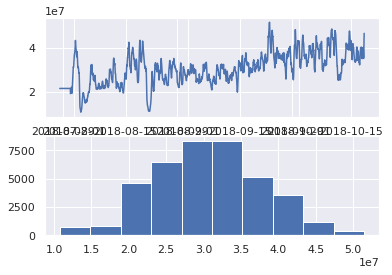

In [ ]:
from scipy.stats import boxcox

data['Board_Temp._1_smooth'], lam = boxcox(data['Board_Temp._1_smooth']) 
data['Board_Temp._2_smooth'], lam = boxcox(data['Board_Temp._2_smooth']) 
data['Board_Temp._3_smooth'], lam = boxcox(data['Board_Temp._3_smooth']) 
data['Board_Temp._4_smooth'], lam = boxcox(data['Board_Temp._4_smooth']) 
data['Board_Temp._5_smooth'], lam = boxcox(data['Board_Temp._5_smooth']) 
data['Board_Temp._6_smooth'], lam = boxcox(data['Board_Temp._6_smooth']) 
data['Board_Temp._7_smooth'], lam = boxcox(data['Board_Temp._7_smooth']) 
data['Board_Temp._8_smooth'], lam = boxcox(data['Board_Temp._8_smooth']) 
data['Board_Temp._9_smooth'], lam = boxcox(data['Board_Temp._9_smooth']) 
data['Board_Temp._10_smooth'], lam = boxcox(data['Board_Temp._10_smooth']) 
data['Board_Deaf_Temp._1_smooth'], lam = boxcox(data['Board_Deaf_Temp._1_smooth']) 
data['Board_Deaf_Temp._6_smooth'], lam = boxcox(data['Board_Deaf_Temp._6_smooth']) 
data['Board_Face_Temp._1_smooth'], lam = boxcox(data['Board_Face_Temp._1_smooth']) 
data['Board_Face_Temp._6_smooth'], lam = boxcox(data['Board_Face_Temp._6_smooth']) 

print('Lambda: %f' % lam)
plt.figure(1)
# line plot
plt.subplot(211)
plt.plot(data['Board_Face_Temp._6_smooth'])
# histogram
plt.subplot(212)
plt.hist(data['Board_Face_Temp._6_smooth'])
plt.show()

# Decomposition

---
In many cases of time series analytics, there is a natural seasonal variation.

A common analysis is to decompose the time series into the three main components:

    Trend: the long-term evolution of the time series
    Seasonality: the reproducible variation within each time period (as previously defined)
    Random: unpredictable variations



In [ ]:
#!pip install statsmodels==0.6.0
#!pip install statsmodels --upgrade

Requirement already up-to-date: scipy==1.2 in /usr/local/lib/python3.6/dist-packages (1.2.0)


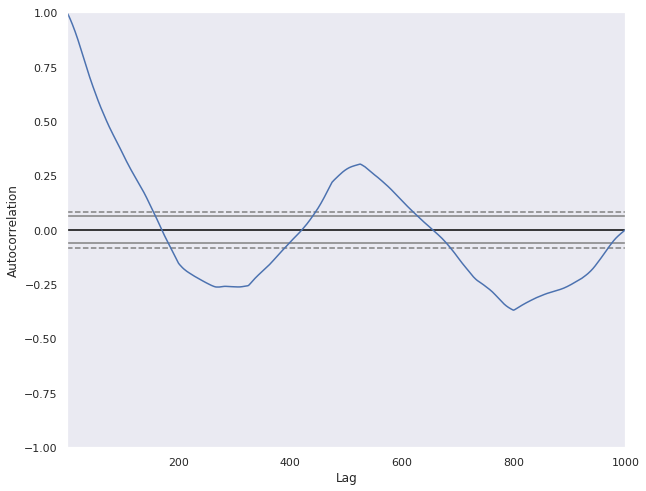

In [ ]:
from pandas.plotting import autocorrelation_plot
#Non Random Walk Correlogram: Шум_int_smooth - trend
autocorrelation_plot(data["Шум_int_smooth"][:1000])
plt.show()

Critical values are at the 1%, 5%, and 10% confidence levels. 

---

Critical Values for ADF:
*   10%: -2.571
*   5%: -2.870
*   1%: -3.449

---

*   p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
*   p-value ≤ 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [ ]:
from statsmodels.tsa.stattools import adfuller
 
adf_test = adfuller(data['Board_Deaf_Temp._6_smooth'])
 
print("ADF = " + str(adf_test[0]))
print("p-value = " + str(adf_test[1]))

ADF = -5.146693428326571
p-value = 1.1284630473390266e-05


This suggests that we can reject the null hypothesis with a significance level of less than 1% (i.e. a low probability that the result is a statistical fluke). Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have
time-dependent structure.


*    Board Temp. 1 - **stat**
ADF = -3.7486516059970416
p-value = 0.003478602025683104
*   Board Temp. 2 - **non-stat**
ADF = -2.7588756970260087
p-value = 0.06439242787430458
*   Board Temp. 3 - **non-stat**
ADF = -2.7073732385594695
p-value = 0.07277104422945574
*   Board Temp. 4 - **stat 1%**
ADF = -3.104563809453904
p-value = 0.02621728452131014
*   Board Temp. 5 - **non-stat**
ADF = -5.902130903002154
p-value = 2.7621693907708326e-07
*   Board Temp. 6 - **stat 1%**
ADF = -4.455070547343195
p-value = 0.0002368552606441095
*   Board Temp. 7 - **non-stat**
ADF = -7.866660656742107
p-value = 5.113210640069673e-12
*   Board Temp. 8 - **stat 1%**
ADF = -4.380705159665627
p-value = 0.00032106165356633927
*   Board Temp. 9 - **non-stat**
ADF = -1.8967636329106732
p-value = 0.33358512834421405
*   Board Temp. 10 - **stat 1%**
ADF = -3.621908456122312
p-value = 0.005355736770229644
*   Board_Face_Temp. 1 - **non-stat**
ADF = -5.407606071099862
p-value = 3.2648094186777934e-06
*   Board_Face_Temp. 6 - **non-stat**
ADF = -5.146693428326571
p-value = 1.1284630473390266e-05
*   Board Deaf Temp. 1 - **non-stat**
ADF = -5.4640882464028175
p-value = 2.4811565057962878e-06
*   Board Deaf Temp. 6 - **non-stat**
ADF = -5.146693428326571
p-value = 1.1284630473390266e-05
*   Шум_int - **stat 1%**
ADF = -2.373994553910456
p-value = 0.14921116315373895
*   Обратная_ЭДС_int - **stat 1%**
ADF = -3.7957391974756534
p-value = 0.0029512106526359784
*   Ср.прир.напр._int  - **stat 1%**
ADF = -4.136109411718771
p-value = 0.0008436505561086243
*   Сум.доз_АПГ_int  - **non-stat**
ADF = -1.8350172508033697
p-value = 0.3632203431385585

# Additive Decomposition

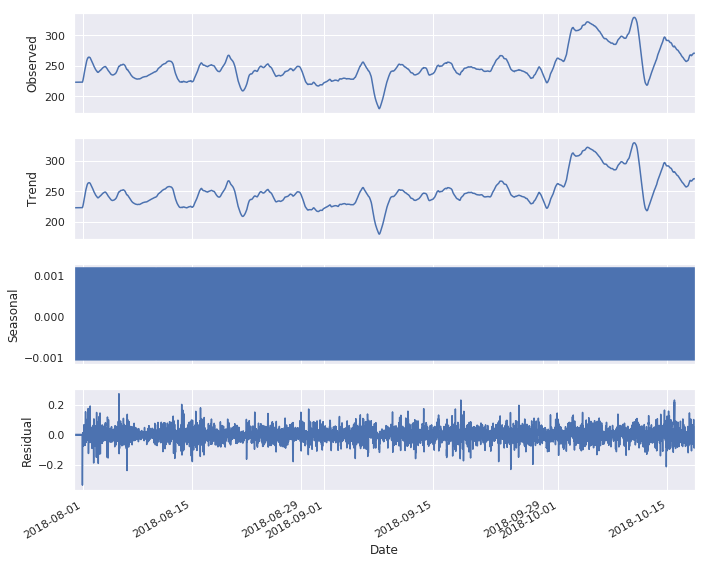

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
#data.set_index('Date', inplace=True)
result = seasonal_decompose(data['Board_Deaf_Temp._6_smooth'], model='additive', freq=30) 

result.plot()
pyplot.show()

# Checking target time series

In [ ]:
target = pd.read_csv('target.csv', sep=';')
target.columns = ["Date", "product_percents"]

target['Date'] =  pd.to_datetime(target['Date']) #format='%Y-%m-%d %H:%M:%S'
print(target.isnull().sum())

Date                 0
product_percents    35
dtype: int64


In [ ]:
target.head()

,Date,product_percents
0,2018-07-28 05:00:00,3.68
1,2018-07-28 14:00:00,3.49
2,2018-07-29 05:00:00,3.61
3,2018-07-29 14:00:00,3.65
4,2018-07-30 05:00:00,3.41


In [ ]:
target_train = target[:131]
target_test = target[131:]
target_train = target_train.set_index('Date').resample('30min').interpolate(method='linear').reset_index()
target_test = target_test.set_index('Date').resample('30min').interpolate(method='linear').reset_index()

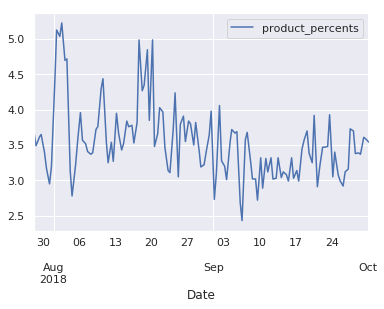

In [ ]:
lines = target_train.plot.line(x = 'Date', y ='product_percents')

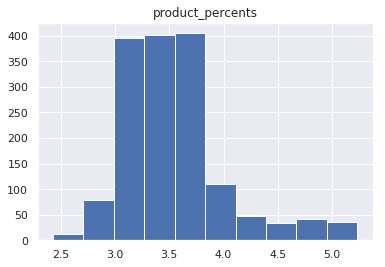

In [ ]:
target_train.hist()
plt.show()

In [ ]:
from scipy.stats import boxcox
target_train['product_percents'], lam = boxcox(target_train['product_percents']) 

In [ ]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(target_train['product_percents'])
print("ADF = " + str(adf_test[0]))
print("p-value = " + str(adf_test[1]))
#non-stat as well

ADF = -5.532954441907892
p-value = 1.7705690799836062e-06


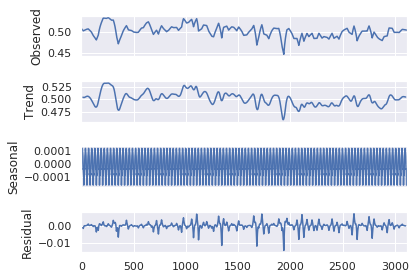

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
#data.set_index('Date', inplace=True)
result = seasonal_decompose(target_train['product_percents'], model='additive', freq=30) 

result.plot()
plt.show()

In [ ]:
# grid search ARIMA parameters for time series
import warnings
from math import sqrt
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.66)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit(disp=0)
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	rmse = sqrt(mean_squared_error(test, predictions))
	return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					rmse = evaluate_arima_model(dataset, order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					print('ARIMA%s RMSE=%.3f' % (order,rmse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [ ]:
# load dataset
series = target_train["product_percents"]
# evaluate parameters
p_values = [0, 1, 2]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=0.013
ARIMA(0, 0, 1) RMSE=0.006
ARIMA(0, 1, 0) RMSE=0.001
ARIMA(0, 1, 1) RMSE=0.001
ARIMA(0, 1, 2) RMSE=0.001
ARIMA(0, 2, 0) RMSE=0.001
ARIMA(0, 2, 1) RMSE=0.001
ARIMA(0, 2, 2) RMSE=0.001
ARIMA(1, 0, 0) RMSE=0.001
ARIMA(1, 0, 1) RMSE=0.001
ARIMA(1, 0, 2) RMSE=0.001
ARIMA(1, 1, 0) RMSE=0.001
ARIMA(1, 1, 1) RMSE=0.001
ARIMA(1, 1, 2) RMSE=0.001
ARIMA(1, 2, 0) RMSE=0.001
ARIMA(1, 2, 1) RMSE=0.001
ARIMA(2, 0, 1) RMSE=0.001
ARIMA(2, 0, 2) RMSE=0.001
ARIMA(2, 1, 0) RMSE=0.001
ARIMA(2, 1, 1) RMSE=0.001
ARIMA(2, 1, 2) RMSE=0.001
ARIMA(2, 2, 0) RMSE=0.001
ARIMA(2, 2, 1) RMSE=0.001
ARIMA(2, 2, 2) RMSE=0.001
ARIMA(4, 0, 1) RMSE=0.001
ARIMA(4, 1, 0) RMSE=0.001
ARIMA(4, 1, 1) RMSE=0.001
ARIMA(4, 1, 2) RMSE=0.001
ARIMA(4, 2, 0) RMSE=0.001
ARIMA(4, 2, 1) RMSE=0.001
ARIMA(4, 2, 2) RMSE=0.001
Best ARIMA(4, 1, 2) RMSE=0.001


In [ ]:
from statsmodels.tsa.stattools import acf

# Create Training and Test
train = target_train["product_percents"]
test = target_test["product_percents"]

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

model = ARIMA(train, order=(0, 1, 0))  
fitted = model.fit(disp=-1)  
fc, se, conf = fitted.forecast(len(target_test), alpha=0.05)  # 95% conf


#prediction = model_fit.forecast()[len(target_test)]

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [ ]:
#target_test = target_test.join(pd.DataFrame(fc))
target_test.columns = ["Date", "product_percents", "prediction"]
target_test.to_csv('target_full.csv')

In [ ]:
!ls

'3min Series (00sec) Outer new.csv'		      target.csv
 boards.jpg					      target_full.csv
'╨í╤Ç╨╡╨┤╨╜╤Å╤Å ╨╝╨░╤ü╤ü╨░ ╨┤╨╛╨╗╨╕ ╨É╨ƒ╨ô New.csv'   target_test.csv
 README.md


In [ ]:
from google.colab import files
files.download('target_full.csv')

In [ ]:
target_test = target_test.reset_index()

In [ ]:
target_test["hour"] = target_test["Date"].apply(lambda x: x.hour)
target_test["minute"] = target_test["Date"].apply(lambda x: x.minute)

In [ ]:
target_test.head()

,Date,product_percents,prediction,hour,minute
0,2018-10-01 14:00:00,NaN,3.539955,14,0
1,2018-10-01 14:30:00,NaN,3.539910,14,30
2,2018-10-01 15:00:00,NaN,3.539865,15,0
3,2018-10-01 15:30:00,NaN,3.539821,15,30
4,2018-10-01 16:00:00,NaN,3.539776,16,0


In [ ]:
target_short = target_test.loc[(((target_test["hour"] == 5) & (target_test["minute"] == 0)) | ((target_test["hour"] == 14) & (target_test["minute"] == 0)))]

In [ ]:
target_short.to_csv('target_short.csv')

In [ ]:
!cat target_short.csv

,Date,product_percents,prediction,hour,minute
0,2018-10-01 14:00:00,,3.5399551282051283,14,0
30,2018-10-02 05:00:00,,3.538608974358975,5,0
48,2018-10-02 14:00:00,,3.5378012820512827,14,0
78,2018-10-03 05:00:00,,3.5364551282051293,5,0
96,2018-10-03 14:00:00,,3.5356474358974372,14,0
126,2018-10-04 05:00:00,,3.534301282051284,5,0
144,2018-10-04 14:00:00,,3.5334935897435917,14,0
174,2018-10-05 05:00:00,,3.5321474358974383,5,0
192,2018-10-05 14:00:00,,3.5313397435897462,14,0
222,2018-10-06 05:00:00,,3.529993589743593,5,0
240,2018-10-06 14:00:00,,3.5291858974359007,14,0
270,2018-10-07 05:00:00,,3.5278397435897473,5,0
288,2018-10-07 14:00:00,,3.527032051282055,14,0
318,2018-10-08 05:00:00,,3.5256858974359018,5,0
336,2018-10-08 14:00:00,,3.5248782051282097,14,0
366,2018-10-09 05:00:00,,3.5235320512820563,5,0
384,2018-10-09 14:00:00,,3.522724358974364,14,0
414,2018-10-10 05:00:00,,3.5213782051282108,5,0
432,2018-10-10 14:00:00,,3.5205705128205187,14,0
462,2018-10-11 05:00:00,,3.5192243589743653

## Result:
chosed ARIMA(0, 1, 0)

# Final merge, pre-processing

In [ ]:
data = data.drop(['Шум', 'Обратная ЭДС', "Ср.прир.напр.", "Сум.доз АПГ", "Board Temp. 1", "Board Temp. 2", "Board Temp. 3", "Board Temp. 4", "Board Temp. 5",
                   "Board Temp. 6", 'Board Temp. 7', "Board Temp. 8", "Board Temp. 9", "Board Temp. 10", "Board Face Temp. 1", "Board Face Temp. 6",
                   "Board Deaf Temp. 1", "Board Deaf Temp. 6", "Шум_int", "Обратная_ЭДС_int", "Ср.прир.напр._int", "Сум.доз_АПГ_int"], axis=1)

In [ ]:
print(data.isnull().sum())

Шум_int_smooth               0
Обратная_ЭДС_int_smooth      0
Ср.прир.напр._int_smooth     0
Сум.доз_АПГ_int_smooth       0
Board_Temp._1_smooth         0
Board_Temp._2_smooth         0
Board_Temp._3_smooth         0
Board_Temp._4_smooth         0
Board_Temp._5_smooth         0
Board_Temp._6_smooth         0
Board_Temp._7_smooth         0
Board_Temp._8_smooth         0
Board_Temp._9_smooth         0
Board_Temp._10_smooth        0
Board_Face_Temp._1_smooth    0
Board_Face_Temp._6_smooth    0
Board_Deaf_Temp._1_smooth    0
Board_Deaf_Temp._6_smooth    0
dtype: int64


In [ ]:
print("Target data time range")
#target.set_index('Date', inplace = True)
print(target_train.Date.min())
print(target_train.Date.max())

#data = data.reset_index()
#data.set_index('Date', inplace = True)
print("Main data time range")
print(data.Date.min())
print(data.Date.max())

Target data time range
2018-07-28 05:00:00
2018-10-01 05:00:00
Main data time range
2018-07-28 05:01:00
2018-10-18 13:58:00


In [ ]:
#data.Date = data.Date - pd.Timedelta(minutes = 1)
data = data.set_index('Date').resample('30Min').mean().reset_index()
data_train = data[(data['Date'] <= "2018-10-01 05:00:00")]
#target_train = target_train.set_index('Date').resample('30Min').interpolate(method='linear').reset_index()

In [ ]:
print("Target data time range")
#target.set_index('Date', inplace=True)
print(target_train.Date.min())
print(target_train.Date.max())

#data.set_index('Date', inplace=True)
print("Main data time range")
print(data_train.Date.min())reset

print(data_train.Date.max())

Target data time range
2018-07-28 05:00:00
2018-10-01 05:00:00
Main data time range
2018-07-28 05:00:00
2018-10-01 05:00:00


In [ ]:
target_train.shape

(3121, 2)

In [ ]:
data_train.shape

(3121, 19)

In [ ]:
#data = pd.merge(data, mass, how='outer', on='Date')
data_train = pd.merge(data_train, target_train, how='outer', on='Date')

In [ ]:
# prepare training dataset
train_size = int(len(data_train) * 0.66)
train, test = data_train[0:train_size], data_train[train_size:]

# Multiple Input Series with LSTM
Try:
*   LSTM
* Bidirectional LSTM
*   ConvLSTM

In [ ]:
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

Using TensorFlow backend.


In [ ]:
# define input sequence and convert to proper structure
lenth = len(data_train)
in_seq1 = np.array(data_train["Шум_int_smooth"]).reshape(lenth, 1)
in_seq2 = np.array(data_train["Сум.доз_АПГ_int_smooth"]).reshape(lenth, 1)
in_seq3 = np.array(data_train["Ср.прир.напр._int_smooth"]).reshape(lenth, 1)
in_seq4 = np.array(data_train["Обратная_ЭДС_int_smooth"]).reshape(lenth, 1)
in_seq5 = np.array(data_train["Board_Temp._1_smooth"]).reshape(lenth, 1)
in_seq6 = np.array(data_train["Board_Temp._2_smooth"]).reshape(lenth, 1)
in_seq7 = np.array(data_train["Board_Temp._3_smooth"]).reshape(lenth, 1)
in_seq8 = np.array(data_train["Board_Temp._4_smooth"]).reshape(lenth, 1)
in_seq9 = np.array(data_train["Board_Temp._5_smooth"]).reshape(lenth, 1)
in_seq10 = np.array(data_train["Board_Temp._6_smooth"]).reshape(lenth, 1)
in_seq11 = np.array(data_train["Board_Temp._7_smooth"]).reshape(lenth, 1)
in_seq12 = np.array(data_train["Board_Temp._8_smooth"]).reshape(lenth, 1)
in_seq13 = np.array(data_train["Board_Temp._9_smooth"]).reshape(lenth, 1)
in_seq14 = np.array(data_train["Board_Temp._10_smooth"]).reshape(lenth, 1)
in_seq15 = np.array(data_train["Board_Face_Temp._1_smooth"]).reshape(lenth, 1)
in_seq16 = np.array(data_train["Board_Face_Temp._6_smooth"]).reshape(lenth, 1)
in_seq17 = np.array(data_train["Board_Deaf_Temp._1_smooth"]).reshape(lenth, 1)
in_seq18 = np.array(data_train["Board_Deaf_Temp._6_smooth"]).reshape(lenth, 1)
out_seq = np.array(data_train["product_percents"]).reshape(lenth, 1)

In [ ]:
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, in_seq3, in_seq4, in_seq5, in_seq6, in_seq7, in_seq8, in_seq9, in_seq10, 
                  in_seq11, in_seq12, in_seq13, in_seq14, in_seq15, in_seq16, in_seq17, in_seq18, out_seq))

# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)

In [ ]:
n_features = X.shape[2]

model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
# fit model
history = model.fit(X, y, epochs = 4000, verbose=0)

W0702 09:06:02.330758 140713793775488 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0702 09:06:02.373768 140713793775488 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0702 09:06:02.382603 140713793775488 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0702 09:06:02.864293 140713793775488 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0702 09:06:03.173422 140713793775488 deprecation.py:323

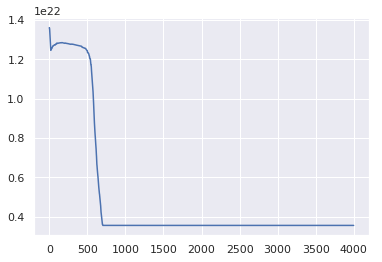

In [ ]:
plt.plot(history.history["loss"])

In [ ]:
import math
print("RMSE: " + str(math.sqrt(min(history.history["loss"]))))

RMSE: 59684019094.73382


In [ ]:
data_test = data[(data['Date'] >= "2018-10-01 05:00:00")]
data_test = pd.merge(data_test, target_test, how = 'inner', on = 'Date')

In [ ]:
print("Target data time range")
#target.set_index('Date', inplace = True)
print(target_test.Date.min())
print(target_test.Date.max())

#data = data.reset_index()
#data.set_index('Date', inplace = True)
print("Main data time range")
print(data_test.Date.min())
print(data_test.Date.max())

Target data time range
2018-10-01 14:00:00
2018-10-18 14:00:00
Main data time range
2018-10-01 14:00:00
2018-10-18 13:30:00


In [ ]:
target_test.shape

(817, 3)

In [ ]:
data_test.shape

(816, 21)

In [ ]:
data_test.head()

,Date,Шум_int_smooth,Обратная_ЭДС_int_smooth,Ср.прир.напр._int_smooth,Сум.доз_АПГ_int_smooth,Board_Temp._1_smooth,Board_Temp._2_smooth,Board_Temp._3_smooth,Board_Temp._4_smooth,Board_Temp._5_smooth,Board_Temp._6_smooth,Board_Temp._7_smooth,Board_Temp._8_smooth,Board_Temp._9_smooth,Board_Temp._10_smooth,Board_Face_Temp._1_smooth,Board_Face_Temp._6_smooth,Board_Deaf_Temp._1_smooth,Board_Deaf_Temp._6_smooth,product_percents,arima_pred
0,2018-10-01 14:00:00,0.010138,1.872682,-3.4256,5.604,48.715555,9.139628e+06,0.647082,9.293790,2.788951e+13,10.964413,3.880415e+09,2.811028e+07,270.513279,684101.940974,6759.832337,3.488866e+07,34.097862,1.464696,NaN,3.539955
1,2018-10-01 14:30:00,0.009676,1.899150,-3.1786,6.652,48.894053,9.130959e+06,0.647082,9.305137,2.820126e+13,10.970273,3.852651e+09,2.824919e+07,270.816539,677907.701087,6823.542076,3.477942e+07,34.114714,1.464868,NaN,3.539910
2,2018-10-01 15:00:00,0.009114,1.930550,-2.4092,6.572,48.972475,9.147807e+06,0.647082,9.312398,2.835499e+13,10.975830,3.834814e+09,2.831084e+07,271.215856,671886.128428,6871.122906,3.472722e+07,34.146791,1.465045,NaN,3.539865
3,2018-10-01 15:30:00,0.008986,1.959750,-1.3788,5.510,48.985820,9.139972e+06,0.647082,9.317985,2.840854e+13,10.983183,3.833318e+09,2.836415e+07,271.520991,668106.377309,6901.128355,3.467575e+07,34.166725,1.465233,NaN,3.539821
4,2018-10-01 16:00:00,0.008878,1.975600,-1.0336,5.378,49.168745,9.228601e+06,0.647082,9.328954,2.852798e+13,11.001946,3.862840e+09,2.866532e+07,272.381751,668300.111019,6990.074149,3.513677e+07,34.266237,1.465614,NaN,3.539776


In [ ]:
data_test = data_test.drop(columns=["arima_pred"])

In [ ]:
# define input sequence and convert to proper structure
lenth = len(data_test)
in_seq1 = np.array(data_test["Шум_int_smooth"]).reshape(lenth, 1)
in_seq2 = np.array(data_test["Сум.доз_АПГ_int_smooth"]).reshape(lenth, 1)
in_seq3 = np.array(data_test["Ср.прир.напр._int_smooth"]).reshape(lenth, 1)
in_seq4 = np.array(data_test["Обратная_ЭДС_int_smooth"]).reshape(lenth, 1)
in_seq5 = np.array(data_test["Board_Temp._1_smooth"]).reshape(lenth, 1)
in_seq6 = np.array(data_test["Board_Temp._2_smooth"]).reshape(lenth, 1)
in_seq7 = np.array(data_test["Board_Temp._3_smooth"]).reshape(lenth, 1)
in_seq8 = np.array(data_test["Board_Temp._4_smooth"]).reshape(lenth, 1)
in_seq9 = np.array(data_test["Board_Temp._5_smooth"]).reshape(lenth, 1)
in_seq10 = np.array(data_test["Board_Temp._6_smooth"]).reshape(lenth, 1)
in_seq11 = np.array(data_test["Board_Temp._7_smooth"]).reshape(lenth, 1)
in_seq12 = np.array(data_test["Board_Temp._8_smooth"]).reshape(lenth, 1)
in_seq13 = np.array(data_test["Board_Temp._9_smooth"]).reshape(lenth, 1)
in_seq14 = np.array(data_test["Board_Temp._10_smooth"]).reshape(lenth, 1)
in_seq15 = np.array(data_test["Board_Face_Temp._1_smooth"]).reshape(lenth, 1)
in_seq16 = np.array(data_test["Board_Face_Temp._6_smooth"]).reshape(lenth, 1)
in_seq17 = np.array(data_test["Board_Deaf_Temp._1_smooth"]).reshape(lenth, 1)
in_seq18 = np.array(data_test["Board_Deaf_Temp._6_smooth"]).reshape(lenth, 1)
out_seq = np.array(data_test["product_percents"]).reshape(lenth, 1)

In [ ]:
x_input = hstack((in_seq1, in_seq2, in_seq3, in_seq4, in_seq5, in_seq6, in_seq7, in_seq8, in_seq9, in_seq10, 
                  in_seq11, in_seq12, in_seq13, in_seq14, in_seq15, in_seq16, in_seq17, in_seq18, out_seq))

# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(x_input, n_steps)

In [ ]:
yhat = model.predict(x_input, verbose=0)

ValueError: ignored

In [ ]:
# demonstrate prediction
#x_input = array([[80, 85], [90, 95], [100, 105]])
#x_input = x_input.reshape((1, n_steps, n_features))
#yhat = model.predict(x_input, verbose=0)
#print(yhat)

In [ ]:
from google.colab import files
files.download('predict')